In [1]:
# import libraries
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

c:\Users\ezlik\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# 1. Random Forest

In [12]:
class RandomForestModel():

    def __init__(self, symbol, start, end=datetime.datetime.today(), n_estimators=100, max_depth=10, max_features=4):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.get_data()
    
    def get_data(self):

        # extract data
        data = yf.download(self.symbol, self.start, self.end)

        # target variable
        target = "Close"

        # predictors
        predictor = ["Open", "High", "Low", "Volume"]

        # create features
        X = data[predictor]
        y = data[target]

        # split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # create model
        self.model = RandomForestRegressor(n_estimators=self.n_estimators, max_depth=self.max_depth, max_features=self.max_features)

        # fit model
        self.model.fit(X_train, y_train)

        # predict
        y_pred = self.model.predict(X_test)

        # evaluate
        print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
        print('R2 Score: %.2f' % r2_score(y_test, y_pred))
        print("#" * 50)

        # generate entry and exit signals
        data["Predicted"] = self.model.predict(data[predictor])
        buysignals = data[data["Close"] < data["Predicted"]]
        sellsignals = data[data["Close"] > data["Predicted"]]

        # position
        data["position"] = np.where(data["Close"] < data["Predicted"], 1, -1)

        # buy and hold strategy
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))

        # strategy returns
        data["strategy"] = data["position"].shift(1) * data["buy_and_hold"]

        # drop na
        data.dropna(inplace=True)

        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals

        return data, buysignals, sellsignals    
    
    def performance_summary(self):

        # calculate sum of buy_and_hold
        # calculate sum
        print("Sum of buy_and_hold:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} Random Forest with {self.n_estimators} trees Model Performance")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot buy and sell signals
        self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
        plt.title(f"Buy and Sell signals of {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        plt.scatter(self.buysignals.index, self.buysignals["Close"], marker="^", color="green")
        plt.scatter(self.sellsignals.index, self.sellsignals["Close"], marker="v", color="red")               

        plt.legend()
        plt.show()

[*********************100%***********************]  1 of 1 completed
Mean squared error: 0.60
R2 Score: 1.00
##################################################
Sum of buy_and_hold:
buy_and_hold    1.212221
strategy        1.545192
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold  strategy
Date                              
2019-01-03      0.900393  1.110627
2019-01-04      0.938830  1.158038
2019-01-07      0.936740  1.160622
2019-01-08      0.954597  1.182747
2019-01-09      0.970808  1.162997
...                  ...       ...
2020-12-24      3.342705  4.462978
2020-12-28      3.462259  4.622599
2020-12-29      3.416160  4.684979
2020-12-30      3.387031  4.725270
2020-12-31      3.360942  4.688873

[504 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2019-01-03
End date,2020-12-31
Total months,24
,Backtest
Annual return,101.5%
Cumulative returns,306.0%
Annual volatility,37.8%
Sharpe ratio,2.04
Calmar ratio,5.86
Stability,0.84
Max drawdown,-17.3%


##################################################


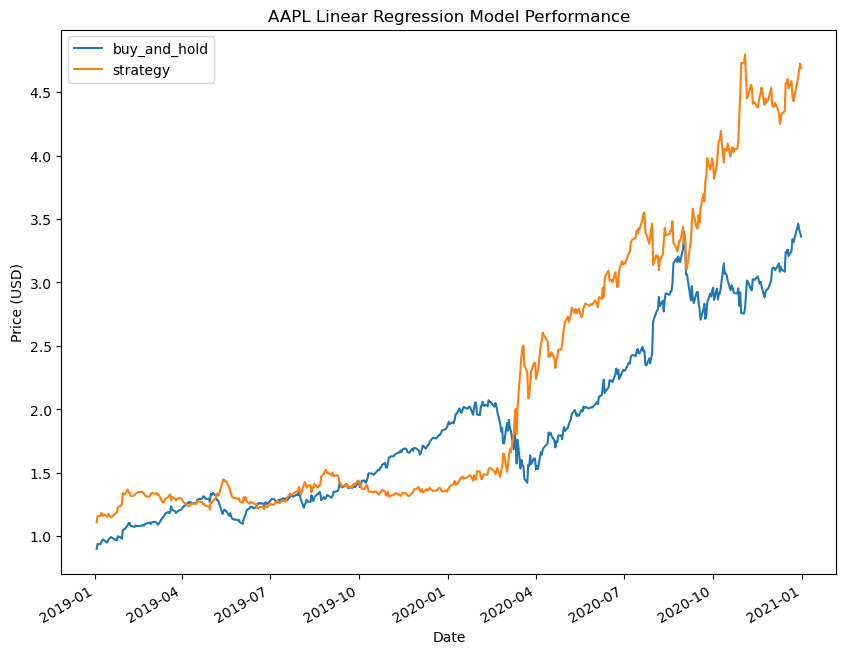

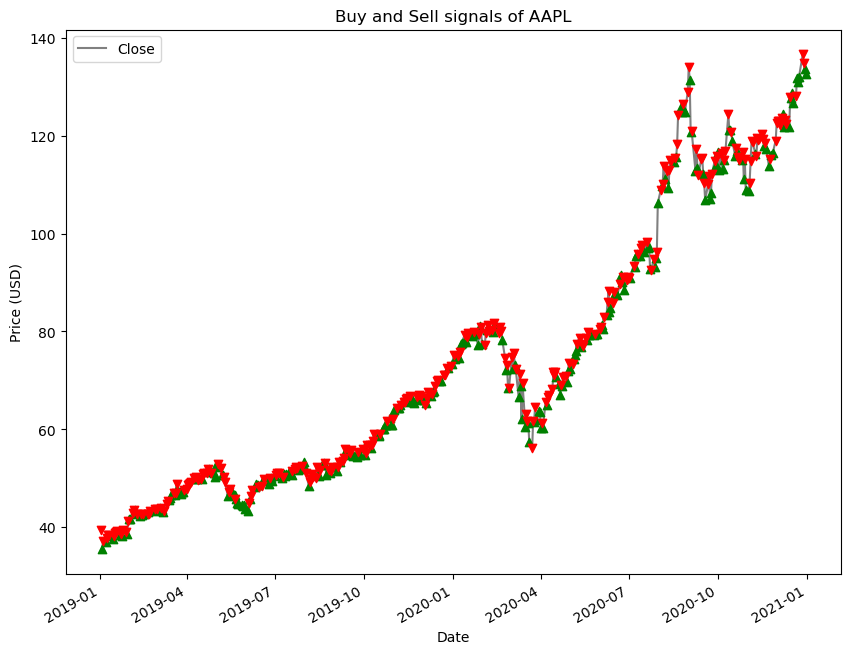

In [13]:
aapl  = RandomForestModel("AAPL", "2019-01-01", "2021-01-01", 100, 10, 4)
aapl.performance_summary()